Пришло время проанализировать результаты эксперимента, который мы провели вместе с командой дата сайентистов. Эксперимент проходил с 2023-05-01 по 2023-05-07 включительно. Для эксперимента были задействованы 2 и 1 группы.

В группе 2 был использован один из новых алгоритмов рекомендации постов, группа 1 использовалась в качестве контроля.

Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR.

Ваша задача — проанализировать данные АB-теста.

Выбрать метод анализа и сравнить CTR в двух группах (мы разбирали t-тест, Пуассоновский бутстреп, тест Манна-Уитни, t-тест на сглаженном ctr (α=5) а также t-тест и тест Манна-Уитни поверх бакетного преобразования). Сравните данные этими тестами. А еще посмотрите на распределения глазами. Почему тесты сработали так как сработали? Опишите потенциальную ситуацию, когда такое изменение могло произойти. Тут нет идеального ответа, подумайте. Напишите рекомендацию, будем ли мы раскатывать новый алгоритм на всех новых пользователей или все-таки не стоит.

In [1]:
import pandahouse
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import hashlib # Делать хеши
#import swifter # Ускорялка метода apply
from scipy import stats # Статистика
%matplotlib inline

In [2]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20230520'
}

In [3]:
# выгрузим из Кликхауса необходимые данные
q = """
    SELECT 
            exp_group,
            user_id,
            sum(action = 'like') as likes,
            sum(action = 'view') as views,
            likes / views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2023-05-01' and '2023-05-07'
            and exp_group in (2, 1)
    GROUP BY exp_group, user_id
    
"""

In [4]:
df = pandahouse.read_clickhouse(q, connection=connection)

In [5]:
# Загрузим датасет
df.head()

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,33,122,0.270492
4,1,18392,7,32,0.218750


In [6]:
#Убедимся, что юзеров одинаковое +- количество в группах
df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
1,10079,10079,10079,10079
2,9952,9952,9952,9952


In [7]:
#увеличим размер в сиборне
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [8]:
df.head()

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,33,122,0.270492
4,1,18392,7,32,0.218750


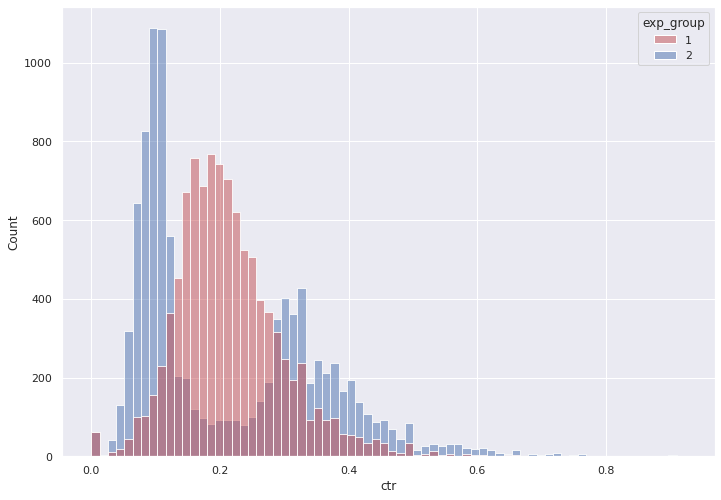

In [9]:
# отрисуем график, чтобы убедиться наглядно 
groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

In [10]:
# проведем т-тест
results = stats.ttest_ind(df[df.exp_group == 2].ctr,
                df[df.exp_group == 1].ctr,
                equal_var=False)
print('p-value:', results.pvalue)
print('statistic:', results.statistic)

p-value: 0.4780623130874935
statistic: -0.7094392041270486


тест не показал различий в группе, хотя на предыдущем графике заметны выбросы, построим боксплоты групп, чтобы убедиться

<AxesSubplot:xlabel='exp_group', ylabel='ctr'>

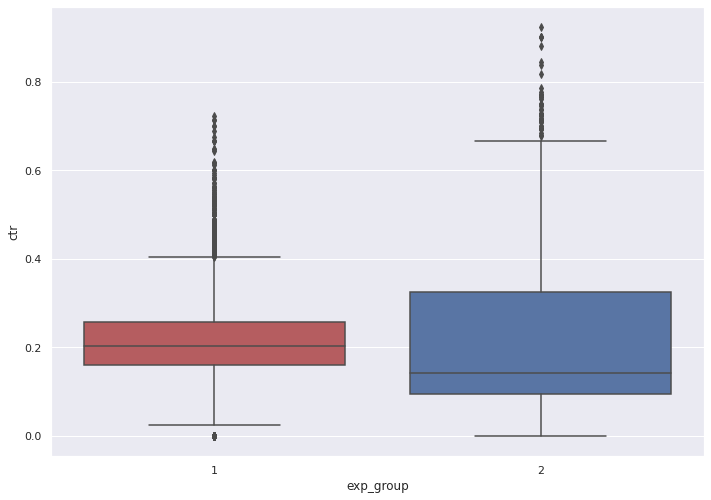

In [11]:
sns.boxplot(data = df, 
              x = 'exp_group', 
              y = 'ctr', 
              palette = ['r', 'b'])

In [12]:
# проведем тест Манна-Уитни 

q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-05-01' and '2023-05-07'
    and exp_group in (2,1)
GROUP BY exp_group, user_id
"""


df = pandahouse.read_clickhouse(q, connection=connection)
stats.mannwhitneyu(df[df.exp_group == 2].ctr, 
                   df[df.exp_group == 1].ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=43704947.5, pvalue=6.0376484617779035e-56)

тест выявил статистически значимые отличия в группах

Проведем т-тест и Манна-Уитни поверх сглаженного CTR

In [13]:
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

In [14]:
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-05-01' and '2023-05-07'
    and exp_group in (2,1)
GROUP BY exp_group, user_id
"""


df = pandahouse.read_clickhouse(q, connection=connection)

In [15]:
global_ctr_1 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()
group1 = df[df.exp_group == 2].copy()
group1['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)

In [16]:
global_ctr_2 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
group2 = df[df.exp_group == 1].copy()
group2['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)

In [17]:
# проведем ttest
result = stats.ttest_ind(group1['smothed_ctr'],
                group2['smothed_ctr'],
                equal_var=False)
print('p-value:', result.pvalue)
print('statistic:', result.statistic)

p-value: 0.0223769815558559
statistic: -2.2841320431616983


t-test не показал статистически значимых различий, посмотрим на гистограмму

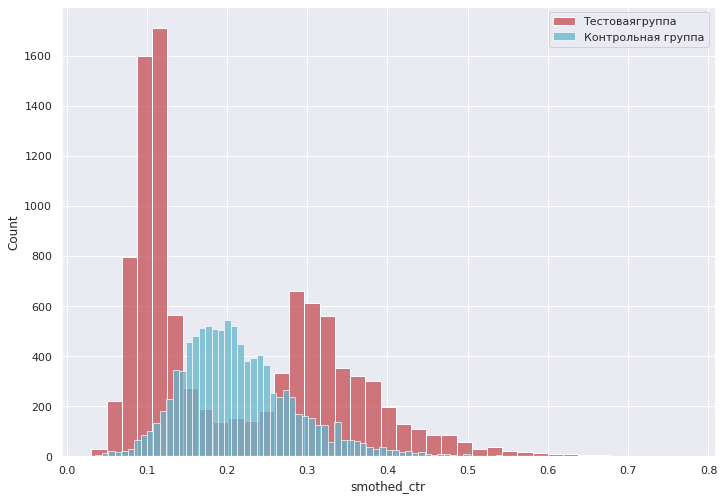

In [18]:
# отрисуем график, чтобы убедиться наглядно 
sns.histplot(data = group1, x='smothed_ctr', label = 'Тестоваягруппа', color = 'r') 
sns.histplot(data = group2, x='smothed_ctr',  label = 'Контрольная группа', color = 'c')   
plt.legend()

да, действительно, графики показывают различия между группами, только пока выигрывает ctr контрольной группы. 

In [19]:
result1 = stats.mannwhitneyu(group1['smothed_ctr'],
                group2['smothed_ctr'],
                alternative = 'two-sided')
print('p-value:', result1.pvalue)
print('statistic:', result1.statistic)

p-value: 1.6163964114270227e-61
statistic: 43381083.0


тест Манна-Уитни замечает различия

Пуассоновский бутстреп поверх сглаженного CTR

In [20]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (2000, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (2000, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

In [21]:
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-05-01' and '2023-05-07'
    and exp_group in (2,1)
GROUP BY exp_group, user_id
"""


df = pandahouse.read_clickhouse(q, connection=connection)

likes1 = df[df.exp_group == 2].likes.to_numpy()
views1 = df[df.exp_group == 2].views.to_numpy()
likes2 = df[df.exp_group == 1].likes.to_numpy()
views2 = df[df.exp_group == 1].views.to_numpy()

In [22]:
ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

In [23]:
len(ctr2)

2000

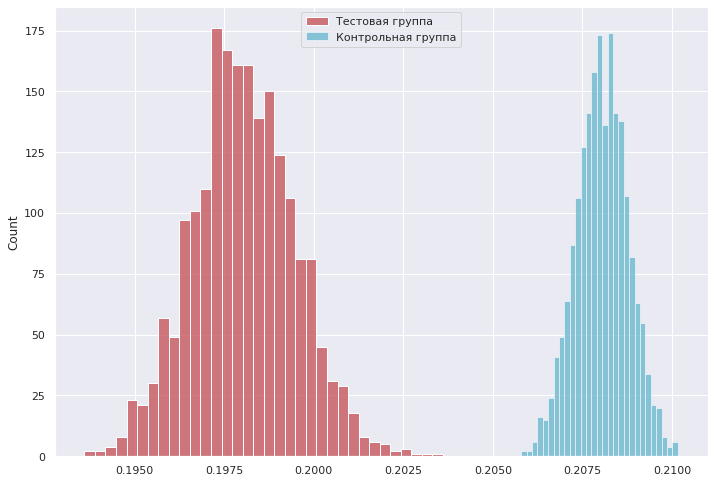

In [24]:
sns.histplot(ctr1, label='Тестовая группа', color= 'r')
sns.histplot(ctr2, label='Контрольная группа', color= 'c')
plt.legend()

Графики не пересекаются, видно, что CTR в контрольной группе выше , чем в тестовой группе.

### Распределение разницы между "глобальными CTR"

<AxesSubplot:ylabel='Count'>

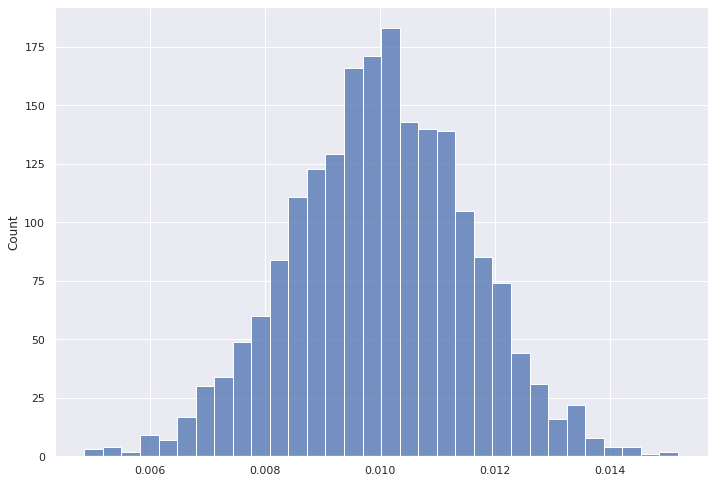

In [25]:
sns.histplot(ctr2 - ctr1)

Видим, что распределение лежит строго после нуля, значит разница между CTR контрольной группы и тестовой - положительная, ненулевая. Значит,помощью пуассоновского бустрепа мы можем утверждать, что CTR группы 1 - контрольной лучше, чем в группе 2 - тестовой.

Протестируем т-тестом и Манна-Уитни поверх бакетногопреобразования

In [26]:
q = """

SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr,
    quantileExact(0.9)(ctr) as ctr9
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2023-05-01' and '2023-05-07'
        and exp_group in (2,1)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

df = pandahouse.read_clickhouse(q, connection=connection)

In [27]:
result_bus = stats.ttest_ind(df[df.exp_group == 2].bucket_ctr,
                df[df.exp_group == 1].bucket_ctr,
                equal_var=False)
print('p-value:', result_bus.pvalue)
print('statistic:', result_bus.statistic)

p-value: 3.4455951649945907e-07
statistic: -5.668234732053979


In [28]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 4 
plt.figure(figsize=(12, 4), dpi=100)

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

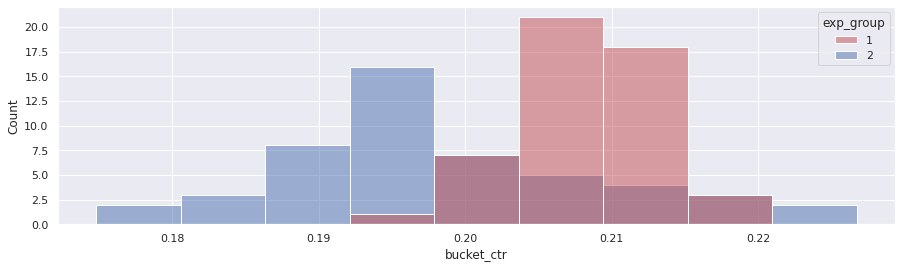

In [29]:
# отрисуем график, чтобы убедиться наглядно 
groups = sns.histplot(data = df, 
              x='bucket_ctr', 
              hue='exp_group', 
              palette= ['r', 'b'],
              alpha=0.5,
              kde=False)

In [30]:
result_bus1 = stats.mannwhitneyu(df[df.exp_group == 2].bucket_ctr,
                df[df.exp_group == 1].bucket_ctr,
                alternative = 'two-sided')
print('p-value:', result_bus1.pvalue)
print('statistic:', result_bus1.statistic)

p-value: 2.859963936492646e-07
statistic: 505.0


In [31]:
result2 = stats.mannwhitneyu(df[df.exp_group == 2].ctr9, 
                   df[df.exp_group == 1].ctr9, 
                   alternative = 'two-sided')
print('p-value:', result2.pvalue)
print('statistic:', result2.statistic)

p-value: 6.344839189967265e-18
statistic: 2500.0


In [32]:
result_ctr9 = stats.ttest_ind(df[df.exp_group == 2].ctr9,
                df[df.exp_group == 1].ctr9,
                equal_var=False)
print('p-value:', result_ctr9.pvalue)
print('statistic:', result_ctr9.statistic)

p-value: 1.2945537024964474e-40
statistic: 23.214341215937406


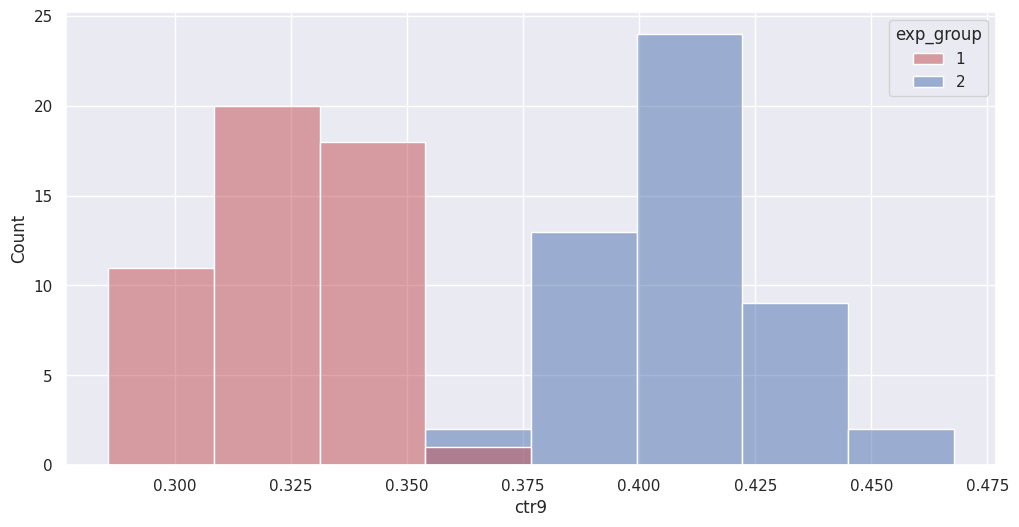

In [33]:
plt.figure(figsize=(12, 6), dpi=100)
# отрисуем график, чтобы убедиться наглядно 
groups = sns.histplot(data = df, 
              x='ctr9', 
              hue='exp_group', 
              palette= ['r', 'b'],
              alpha=0.5,
              kde=False)

## Вывод по проделанной работе

Как мы знаем из задания эксперимент проходил с 2023-05-01 по 2023-05-07 включительно. Для эксперимента были задействованы 2 и 1 группы.В группе 2 был использован один из новых алгоритмов рекомендации постов, группа 1 использовалась в качестве контроля.

Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR.

Т-тест не показал различий в группах, хотя на графиках мы их налюдаем, отрисовка боксплота показала большие выбросы, в этом и есть причина, что т-тест не прокрасил различий. На этом же посчитанном CTR тест Манна-Уитни показал статистически значимые различия медлу группами. 

Далее проводились тесты на сглаженном CTR - тест Стьюдента и тест Манна-Уитни. Т-тест также не прокрасил различий, на графике глазами мы убедились, что различия есть. Тест Манна-Уитни показал статистически значимые различия в группах и на цифрах, и на графиках. Результат CTR контрольной группы лучше, чем в тестовой. 

Пуассоновский бутстрап на сглаженном CTR также показал статистически значимые отличия. 
На графиках видно, что CTR группы 1 - контрольной лучше, чем в группе 2 - тестовой.

Т-тест и Манна-Уитни поверх бакетного преобразования - оба теста выявили различия в группах.

Почему тесты сработали так как сработали? Опишите потенциальную ситуацию, когда такое изменение могло произойти. Тут нет идеального ответа, подумайте. Напишите рекомендацию, будем ли мы раскатывать новый алгоритм на всех новых пользователей или все-таки не стоит.


Конечно, не стоит раскатывать новый алгоритм на всех пользователей, практически все методы продемонстрировали значимые отличия, бустрап показал CTR контрольной группы выше, чем CTR тестовой группы.
Почему есть отличия в группах? Сложно сказать, что послужило причиной и когда. Возможно, тест был запущен одновременно с тестированием еще одной рекомендательной системы в это же время. Часть пользователей пересекались по группам, то есть одновременно им показывали обе новые системы - некорректно разбили юзеров на тестовую и контрольную группы.

